In [2]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

# Attempt to unmount the drive if it's already mounted and remove the directory
try:
  drive.flush_and_unmount()
except ValueError:
  pass # Drive was not mounted, continue

# Explicitly remove and recreate the mount point directory
if os.path.exists('/content/drive/'):
    os.system('rm -rf /content/drive/')
os.makedirs('/content/drive/', exist_ok=True)

drive.mount('/content/drive/', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


In [3]:
# Paths
CSV  = "/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/processed/metadata.csv"
RUNS = "/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs"

# Presence weights (from 03_train_presence.ipynb)
PRES_W = f"{RUNS}/presence_mobilenetv2.pt"
# Segmentation weights (from 04_train_segmentation.ipynb, upgraded)
SEG_W  = f"{RUNS}/unet_resnet34_aquavplant.pt"

# Installs (only needed once per session)
!pip -q install segmentation-models-pytorch==0.3.3 timm==0.9.2 albumentations==1.4.7 --no-cache-dir

import os, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, confusion_matrix
)
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 239.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 137.2 MB/s eta 0:00:00


'cpu'

### Load metadata and build leak-free splits

In [4]:
df = pd.read_csv(CSV)

# Presence (Bangladesh, leak-free split from base_stem logic)
cls_train = df.query("source=='bangladesh_augmented' and split=='train'").reset_index(drop=True)
cls_val   = df.query("source=='bangladesh_augmented' and split=='val'").reset_index(drop=True)
cls_test  = df.query("source=='bangladesh_augmented' and split=='test'").reset_index(drop=True)

# Segmentation (AqUavPlant)
seg_train = df.query("source=='aquavplant' and split=='train'").reset_index(drop=True)
seg_val   = df.query("source=='aquavplant' and split=='val'").reset_index(drop=True)
seg_test  = df.query("source=='aquavplant' and split=='test'").reset_index(drop=True)

print("Presence  — train/val/test:", len(cls_train), len(cls_val), len(cls_test))
print("Segment   — train/val/test:", len(seg_train), len(seg_val), len(seg_test))

Presence  — train/val/test: 2603 643 804
Segment   — train/val/test: 148 27 31


### Datasets & DataLoaders (match training preprocessing)

In [5]:
# === Presence transforms (resize+normalize to ImageNet stats) ===
SIZE_CLS = 224
tfm_cls = A.Compose([
    A.LongestMaxSize(max_size=SIZE_CLS),
    A.PadIfNeeded(min_height=SIZE_CLS, min_width=SIZE_CLS, border_mode=0, value=(128,128,128)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

class PresenceDataset(Dataset):
    def __init__(self, frame, tfm):
        self.df = frame.reset_index(drop=True); self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = np.array(Image.open(r.image_path).convert("RGB"))
        x = self.tfm(image=img)["image"]
        y = np.float32(r.has_hyacinth)
        return x, y

dl_val_cls  = DataLoader(PresenceDataset(cls_val,  tfm_cls), batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
dl_test_cls = DataLoader(PresenceDataset(cls_test, tfm_cls), batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# === Segmentation transforms (match training SIZE & normalization) ===
SIZE_SEG = 512
tfm_seg = A.Compose([
    A.LongestMaxSize(max_size=SIZE_SEG),
    A.PadIfNeeded(min_height=SIZE_SEG, min_width=SIZE_SEG, border_mode=0, value=(128,128,128), mask_value=0),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

class AqSegDataset(Dataset):
    def __init__(self, frame, tfm):
        self.df = frame.reset_index(drop=True); self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = np.array(Image.open(r.image_path).convert("RGB"))
        msk = np.array(Image.open(r.mask_path).convert("L"))
        if msk.max() > 1: msk = (msk > 127).astype("uint8")  # ensure {0,1}
        aug = self.tfm(image=img, mask=msk)
        x = aug["image"]
        y = aug["mask"][None, ...].float()
        return x, y

dl_val_seg  = DataLoader(AqSegDataset(seg_val,  tfm_seg), batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
dl_test_seg = DataLoader(AqSegDataset(seg_test, tfm_seg), batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# quick peek
next(iter(dl_val_seg))[0].shape, next(iter(dl_val_cls))[0].shape

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([4, 3, 512, 512]), torch.Size([64, 3, 224, 224]))

### Rebuild and load models (weights from training)

In [6]:
# Presence: MobileNetV2 + linear(1)
presence_model = torch.hub.load('pytorch/vision:v0.14.1','mobilenet_v2', pretrained=False)
presence_model.classifier[1] = nn.Linear(presence_model.last_channel, 1)
presence_model.load_state_dict(torch.load(PRES_W, map_location=device))
presence_model = presence_model.to(device).eval()

# Segmentation: U-Net (ResNet-34 encoder, pretrained)
seg_model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1).to(device)
seg_model.load_state_dict(torch.load(SEG_W, map_location=device))
seg_model.eval()

print("✅ Models loaded and on", device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.14.1" to /root/.cache/torch/hub/v0.14.1.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Models loaded and on cpu


### Presence evaluation (val): metrics + confusion heatmap + ROC

{'acc': 0.7216, 'prec': 0.4667, 'rec': 0.8805, 'f1': 0.61, 'auc': np.float64(0.8696)}
Best threshold (Youden J): 0.352
Best threshold (F1): 0.900
youden_j   t=0.352 → acc=0.701, F1=0.607
f1         t=0.900 → acc=0.788, F1=0.620
Saved thresholds to: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs


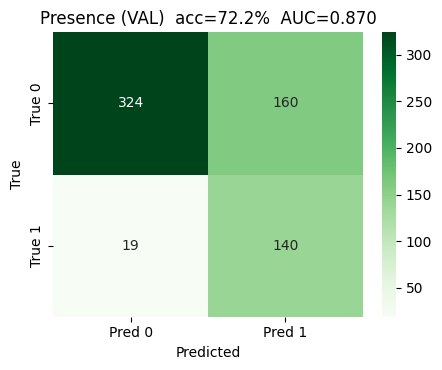

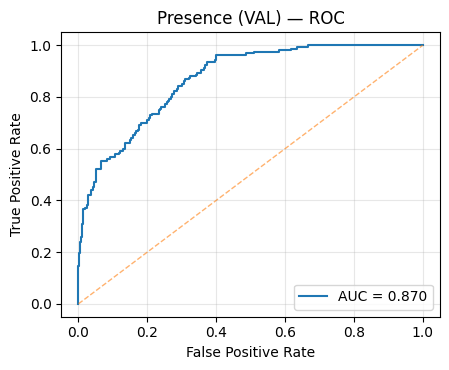

In [18]:
@torch.no_grad()
def eval_presence(model, loader, device, thresh=0.5):
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        prob = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        ys.extend(yb.cpu().numpy().astype(int).tolist())
        ps.extend(prob.tolist())
    ys = np.array(ys); ps = np.array(ps)
    preds = (ps > thresh).astype(int)
    acc = accuracy_score(ys, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(ys, preds, average='binary', zero_division=0)
    auc = roc_auc_score(ys, ps)
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc, ys=ys, ps=ps, preds=preds)

res_val = eval_presence(presence_model, dl_val_cls, device, thresh=0.5)
print({k: round(v,4) for k,v in res_val.items() if k not in ("ys","ps","preds")})

from sklearn.metrics import roc_curve, f1_score, accuracy_score
import numpy as np, json, os

ys, ps = np.array(res_val["ys"]), np.array(res_val["ps"])

# Youden’s J statistic (maximizes TPR-FPR)
fpr, tpr, thr = roc_curve(ys, ps)
t_best_j = float(thr[np.argmax(tpr - fpr)])

# 2️F1-maximizing threshold
cands = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(ys, (ps > t).astype(int)) for t in cands]
t_best_f1 = float(cands[np.argmax(f1s)])

print(f"Best threshold (Youden J): {t_best_j:.3f}")
print(f"Best threshold (F1): {t_best_f1:.3f}")

# evaluate at both thresholds
for name, T in {"youden_j": t_best_j, "f1": t_best_f1}.items():
    preds = (ps > T).astype(int)
    acc = accuracy_score(ys, preds)
    f1  = f1_score(ys, preds)
    print(f"{name:<10} t={T:.3f} → acc={acc:.3f}, F1={f1:.3f}")


# save chosen threshold for later use
RUNS = "/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs"
with open(os.path.join(RUNS, "presence_threshold.json"), "w") as f:
    json.dump({"youden_j": t_best_j, "f1": t_best_f1}, f)
print("Saved thresholds to:", RUNS)

# Confusion matrix
cm = confusion_matrix(res_val["ys"], res_val["preds"])
plt.figure(figsize=(4.6,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title(f"Presence (VAL)  acc={res_val['acc']*100:.1f}%  AUC={res_val['auc']:.3f}")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(res_val["ys"], res_val["ps"])
plt.figure(figsize=(4.6,3.8))
plt.plot(fpr, tpr, label=f"AUC = {res_val['auc']:.3f}")
plt.plot([0,1],[0,1],'--',lw=1,alpha=0.6)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Presence (VAL) — ROC"); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

### Presence evaluation (test) — optional final numbers

In [8]:
res_test = eval_presence(presence_model, dl_test_cls, device, thresh=0.5)
print("Presence (TEST):", {k: round(v,4) for k,v in res_test.items() if k not in ("ys","ps","preds")})

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Presence (TEST): {'acc': 0.7239, 'prec': 0.4684, 'rec': 0.899, 'f1': 0.6159, 'auc': np.float64(0.9001)}


### Segmentation evaluation (val): IoU & Dice + threshold sweep

In [9]:
def iou_dice_from_logits(logits, target, thresh=0.5, eps=1e-7):
    prob = torch.sigmoid(logits)
    pred = (prob > thresh).float()
    inter = (pred*target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - inter
    iou  = (inter + eps) / (union + eps)
    dice = (2*inter + eps) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps)
    return iou, dice

@torch.no_grad()
def eval_seg(model, loader, device, thresh=0.5):
    model.eval(); ious=[]; dices=[]
    for xb, mb in loader:
        xb, mb = xb.to(device, non_blocking=True), mb.to(device, non_blocking=True)
        logits = model(xb)
        iou, dice = iou_dice_from_logits(logits, mb, thresh=thresh)
        ious += iou.cpu().tolist()
        dices += dice.cpu().tolist()
    return float(np.mean(ious)), float(np.mean(dices))

# Default 0.5 and a sweep
miou, mdice = eval_seg(seg_model, dl_val_seg, device, thresh=0.5)
print(f"Seg (VAL) @0.50 → IoU={miou:.4f}  Dice={mdice:.4f}")

for t in (0.30, 0.40, 0.50, 0.60):
    i, d = eval_seg(seg_model, dl_val_seg, device, thresh=t)
    print(f"  thresh {t:.2f} → IoU={i:.4f}, Dice={d:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Seg (VAL) @0.50 → IoU=0.6207  Dice=0.7400
  thresh 0.30 → IoU=0.6151, Dice=0.7333
  thresh 0.40 → IoU=0.6186, Dice=0.7372
  thresh 0.50 → IoU=0.6207, Dice=0.7400
  thresh 0.60 → IoU=0.6219, Dice=0.7419


### Quick qualitative panel (no saving): Image | Ground Truth | Pred

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


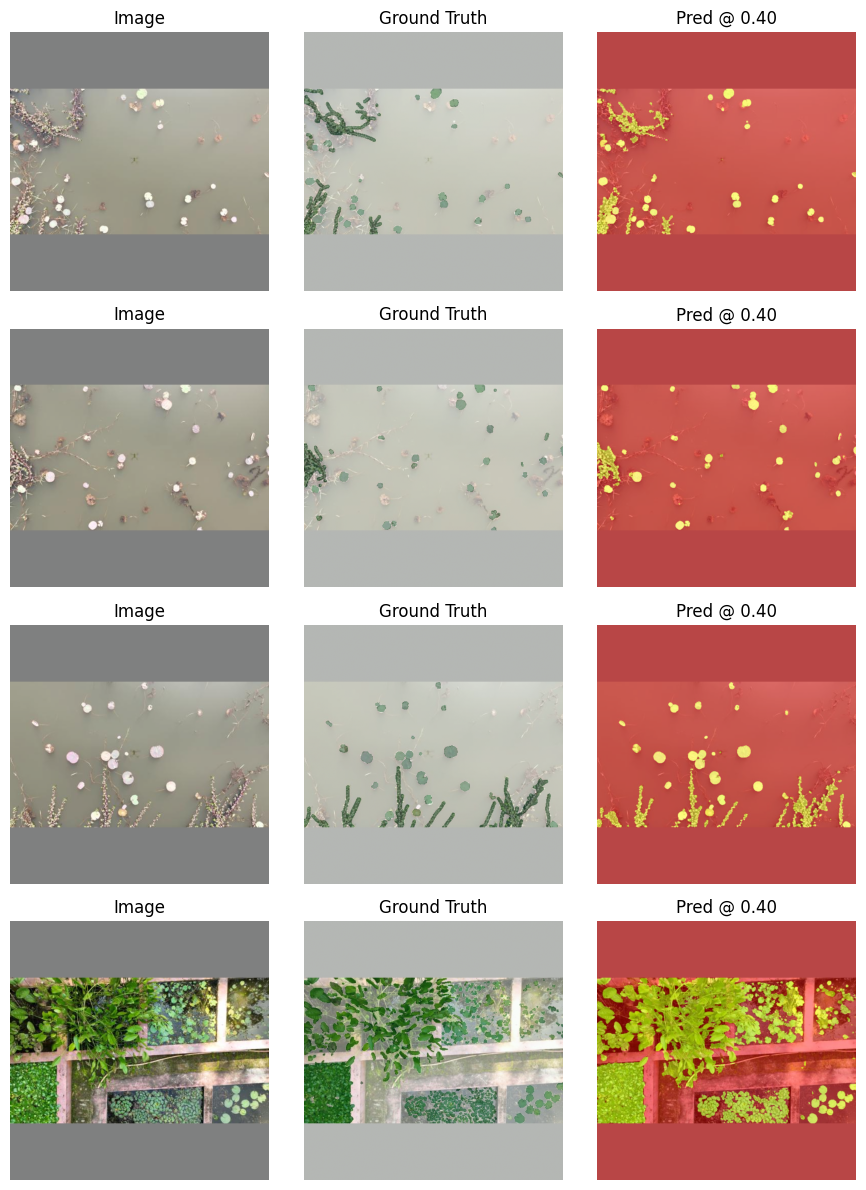

In [16]:
def _denorm(x):
    # reverse A.Normalize(mean,std) roughly for display
    mean = np.array([0.485,0.456,0.406])[None,None,:]
    std  = np.array([0.229,0.224,0.225])[None,None,:]
    x = x * std + mean
    return np.clip(x, 0, 1)

@torch.no_grad()
def show_seg_samples(model, loader, device, k=4, thresh=0.4):
    xb, mb = next(iter(loader))
    xb, mb = xb.to(device), mb.to(device)
    logits = model(xb); prob = torch.sigmoid(logits); pred = (prob > thresh).float()
    k = min(k, xb.size(0))
    plt.figure(figsize=(9, 3*k))
    for i in range(k):
        img = xb[i].detach().cpu().permute(1,2,0).numpy(); img = _denorm(img)
        gt  = mb[i].detach().cpu().squeeze().numpy()
        pr  = pred[i].detach().cpu().squeeze().numpy()
        ax = plt.subplot(k,3,3*i+1); ax.imshow(img); ax.axis("off"); ax.set_title("Image")
        ax = plt.subplot(k,3,3*i+2); ax.imshow(img); ax.imshow(gt, alpha=0.45, cmap="Greens"); ax.axis("off"); ax.set_title("Ground Truth")
        ax = plt.subplot(k,3,3*i+3); ax.imshow(img); ax.imshow(pr, alpha=0.45, cmap="autumn"); ax.axis("off"); ax.set_title(f"Pred @ {thresh:.2f}")
    plt.tight_layout(); plt.show()

show_seg_samples(seg_model, dl_val_seg, device, k=4, thresh=0.4)  # use best threshold from sweep

### Evaluate segmentation on TEST split

In [11]:
miou_t, mdice_t = eval_seg(seg_model, dl_test_seg, device, thresh=0.4)
print(f"Seg (TEST) @0.40 → IoU={miou_t:.4f}  Dice={mdice_t:.4f}")

Seg (TEST) @0.40 → IoU=0.7104  Dice=0.8252


In [12]:
from sklearn.metrics import f1_score

ys, ps = res_val["ys"], res_val["ps"]
for t in [0.3,0.4,0.5,0.6]:
    preds = (ps > t).astype(int)
    acc = accuracy_score(ys, preds)
    f1  = f1_score(ys, preds)
    print(f"Thresh={t:.2f}  Acc={acc:.3f}  F1={f1:.3f}")

Thresh=0.30  Acc=0.692  F1=0.601
Thresh=0.40  Acc=0.705  F1=0.607
Thresh=0.50  Acc=0.722  F1=0.610
Thresh=0.60  Acc=0.733  F1=0.611
